# Key ECB interest rates

Key ECB interest rates do not represent euribor rates directly, but they have strong correlation. 

The Governing Council of the ECB sets the key interest rates for the euro area:  
- The interest rate on the main refinancing operations (MRO), which provide the bulk of liquidity to the banking system.
- The rate on the deposit facility, which banks may use to make overnight deposits with the Eurosystem.
- The rate on the marginal lending facility, which offers overnight credit to banks from the Eurosystem.  

(source: [ecb.europa.eu](https://www.ecb.europa.eu/stats/policy_and_exchange_rates/key_ecb_interest_rates/html/index.en.html))

The governing council holds a meeting ~~monthly~~ where changes to monetary policies are made, including changes to these key interest rates. A press conference follows these meetings, where the reasoning behind the changes are disclosed. The textual data of the said conferences can gives us valuable insights on the non-numeric factors that affect on the interest rates. To assure that this data is applicable to euribor rates as well, we'll prove the strong correlation between the key ECB interest rates and euribor rates.

In [44]:
import pandas as pd
# Read the ECB key rates and euribor rates data
key_rates = pd.read_csv("ECB Data Portal_20231016130234.csv")
euribor_rates = pd.read_csv('euribor_rates.csv')

# Unify the indices by date
key_rates.set_index("DATE", inplace=True)
key_rates.index = pd.to_datetime(key_rates.index)
key_rates.index = key_rates.index.to_period('M')

euribor_rates['DATE'] = pd.to_datetime(euribor_rates[['Year', 'Month']].assign(DAY=1))
euribor_rates.set_index('DATE', inplace=True)
euribor_rates.index = euribor_rates.index.to_period('M')

# Drop redundant columns
key_rates = key_rates.drop(columns=['TIME PERIOD'])
euribor_rates = euribor_rates.drop(columns=['Year', 'Month'])

# Convert ECB daily data into monthly, using the mode of each month
key_rates = key_rates.resample('M').agg(lambda x: x.mode().iloc[0])

# Merge euribor and key rates data
data = euribor_rates.join(key_rates, how='inner')

# Simplify column names
data = data.rename(columns={data.columns[0]: 'euribor', data.columns[1]: 'deposit facility', data.columns[2]: 'marginal lending facility', data.columns[3]: 'MRO'})

# Use Pandas corr method to calculate correlation coeffecients (Pearson's r)
print(data['euribor'].corr(data['deposit facility']))
print(data['euribor'].corr(data['marginal lending facility']))
print(data['euribor'].corr(data['MRO']))


0.9831685193857436
0.9866887664672079
0.9906718746449358


As we see above, the 3 month euribor rate strongly correlate to each key interest rate (with corresponding Pearons r values 0.98, 0.99 and 0.99). In addition to the correlation coefficients, we can standardize the key rates and euribor values to visually show the correlation.

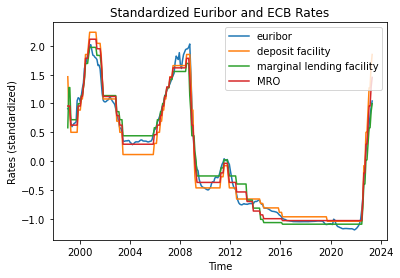

In [45]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
scaler = StandardScaler()

euribor_std = scaler.fit_transform(data[['euribor']])
key_rates_std = scaler.fit_transform(data[['deposit facility', 'marginal lending facility', 'MRO']])
data_std = np.concatenate((euribor_std, key_rates_std), axis=1)

std_df = pd.DataFrame(data_std, columns=['euribor', 'deposit facility', 'marginal lending facility', 'MRO'])
std_df.index = data.index.to_timestamp()

plt.plot(std_df, label=['euribor', 'deposit facility', 'marginal lending facility', 'MRO'])
plt.xlabel('Time')
plt.ylabel('Rates (standardized)')
plt.legend()
plt.title('Standardized Euribor and ECB Rates')
plt.show()
